# Show Frequency Variation Across The Simulations With Varying Iext,eps1 Terms

6/22/18: In our parameter sweep variation of 20 second signals for the TVB model with only varying parameters iext,eps1, we want to conduct MNE-based STFT decomposition into TFR and demonstrate variation with this varying parameter sets.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import io
import json
import mne
np.random.seed(123456789)
sys.path.append('../../../')
from tvb.simulator.lab import *
import tvbsim

# to run simulation and post processing and data loading
from tvbsim.io.patient.subject import Subject
from tvbsim.io.simdata.loadtvbdata import StructuralDataLoader
from tvbsim.io.loadsimdataset import LoadSimDataset
from tvbsim.base.constants.config import Config

from tvbsim.base.preprocess.mne.main import FreqAnalysis

from tvbsim.visualize.old import plotts

# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# configuration and plotting
config = Config() 
config.figures.MATPLOTLIB_BACKEND="qt5" #"Qt4Agg" #"inline"
config.figures.SHOW_FLAG=True

figdir = os.path.join('/Users/adam2392/Documents/figures/raw_freq_analysis/')

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext line_profiler
%load_ext memory_profiler
%matplotlib inline
%load_ext autoreload
%autoreload 2

   INFO  log level set to INFO


In [2]:
def load_raw_data(patdatadir, datafile, metadatadir, patient, reference):
    loader = LoadSimDataset(root_dir=patdatadir, 
                                datafile=datafile, 
                                rawdatadir=metadatadir, 
                                patient=patient,
                                reference=reference, 
                                preload=True)
    # get filtered/referenced rawdata
    epits = loader.epits
    rawdata = loader.rawdata 
    metadata = loader.getmetadata()

    return epits, rawdata, metadata

def load_real_data(patient, rawdatadir, idatafile, type_recording='sz', reference='monopolar'):
    # if we are clipping the datasets:
    loader = Subject(name=patient,
                    root_dir=rawdatadir,
                    preload=True,
                    SIM=False)
    seiz_recordings = loader.seizure_recordings
    ii_recordings = loader.interictal_recordings
    print("These are our seizure recordings!: ", loader.seizure_recordings)
    print("These are our interictal recordings!: ", loader.interictal_recordings)
#     if type_recording == 'sz':
#         idatafile = [idx for idx, name in enumerate(loader.seizure_files) if datafile in name]
#     elif type_recording == 'ii':
#         idatafile = [idx for idx, name in enumerate(loader.interictal_files) if datafile in name]
#     assert len(idatafile) == 1
#     idatafile = idatafile[0]

    # extract raw and metadata
    rawdata, metadata = loader.load_dataset(idatafile,  
                                            reference=reference, 
                                            sync=True)
    print(rawdata.shape)
    print(metadata.keys())
    return rawdata, metadata

def compute_timepoints(winsize, stepsize, samplerate, numtimepoints):
    # Creates a [n,2] array that holds the time range of each window
    # in the analysis over sliding windows.

    # trim signal and then convert into milliseconds
    # numtimepoints = numtimepoints - numtimepoints%(self.samplerate/6)
    timepoints_ms = numtimepoints * 1000. / samplerate

    # create array of indices of window start and end times
    timestarts = np.arange(0, timepoints_ms - winsize + 1, stepsize)
    timeends = np.arange(winsize - 1, timepoints_ms, stepsize)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts[:, np.newaxis],
                           timeends[:, np.newaxis], axis=1)
    return timepoints

In [3]:
patient = 'id001_bt'

# load in empirical and meta structural data
outputdatadir = '/Users/adam2392/Downloads/simexp/tt=1/'
root_dir = os.path.join('/Users/adam2392/Downloads/tngpipeline/', patient)
loader = StructuralDataLoader(root_dir = root_dir)

idatafile = 0
rawdata, realmetadata = load_real_data(patient, root_dir, idatafile, 
                                   type_recording='sz', reference='monopolar')

2018-06-26 15:52:05,812 - DEBUG - StructuralDataLoader - 
Already renamed seeg.xyz possibly!

2018-06-26 15:52:05,813 - DEBUG - StructuralDataLoader - 
Already renamed gaininv.mat possibly!

2018-06-26 15:52:05,815 - INFO - tvbsim.io.readers.read_connectivity - Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
2018-06-26 15:52:05,835 - INFO - tvbsim.io.readers.read_connectivity - Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
NOT USING SUBCORT
2018-06-26 15:52:18,777 - DEBUG - StructuralDataLoader - 
Loaded in seeg xyz coords!

2018-06-26 15:52:24,514 - DEBUG - StructuralDataLoader - 
Mapped contacts to regions!

2018-06-26 15:52:24,516 - 

In [4]:
# get the iext and eps1 parameters from json file name
simexpdir = '/Users/adam2392/Downloads/simexp/tt=1/'
jsonfilepaths = []
for root, dirs, files in os.walk(simexpdir):
    for file in files:
        if file.endswith('.json'):
            jsonfilepaths.append(os.path.join(root, file))

jsonfile = jsonfilepaths[0]

parameters = jsonfile.split('.json')[0].split(patient+'_')[-1]
iext, eps1 = parameters.split('_')

print(iext, eps1)

('2.86', '-0.5')


# Prototype Some Functions

Prototype how to read in the data here just to demonstrate the code.

In [22]:
# define files we want to analyze - defined by their parameter sweep     
iext_sweep = np.linspace(2.5,3.5,11)
eps1_sweep = np.linspace(-0.5,0.5,11)
i = "{}_{}".format(iext, eps1)
outputfilename = os.path.join(outputdatadir,
            '{}_{}.npz'.format(patient, i))
metafilename = os.path.join(outputdatadir,
            '{}_{}.json'.format(patient, i))

In [23]:
with io.open(jsonfile, encoding="utf8") as f:
    json_str = f.read()
metadata = json.loads(json_str)
print(metadata.keys())

datafile = metadata['simfilename']
# debug messages
print("Datafile we loaded was: ", datafile)
print(rawdata.shape)
print(realmetadata.keys())
print(realmetadata['rawfilename'])

[u'x0pz', u'conn_params', u'clinpzregs', u'coupling_params', u'ezregs', u'pzindices', u'samplerate', u'simfilename', u'chanlabels', u'integrator_params', u'ezindices', u'regions', u'model_params', u'chanxyz', u'gainmat', u'x0norm', u'offsetind', u'onsetind', u'monitor_params', u'pzregs', u'clinezregs', u'regions_centers', u'x0ez']
('Datafile we loaded was: ', u'/Users/adam2392/Downloads/simexp/id001_bt_2.86_-0.5.npz')
(97, 766976)
['ez_region', 'offsetsec', 'reference', 'onsetsec', 'type', 'offsetind', 'contact_regs', 'rawfilename', 'onsetind', 'bad_channels', 'record_date', 'lowpass_freq', 'region_labels', 'non_eeg_channels', 'samplerate', 'chanxyz', 'linefreq', 'highpass_freq', 'chanlabels']
/Users/adam2392/Downloads/tngpipeline/id001_bt/seeg/fif/BTcrisepartielle+preictalspiking_0009.raw.fif


In [12]:
%%time
###############################################################
# Run Real freq analysis
winsize = 5000
stepsize = 2500
samplerate = realmetadata['samplerate']
fmin = 0.5
fmax = samplerate // 2

freqs = np.arange(1., samplerate//2, 5.)
waveletfreqs = 2**(np.arange(1.,9.,1./5))

# for binning frequencies
freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}

# run psd analysis
real_freqanalysis = FreqAnalysis(winsize, stepsize, samplerate, freqs)
psd, freqs = real_freqanalysis.psd(rawdata, fmin, fmax, psdtype='welch')
real_freqanalysis.compute_samplepoints(rawdata.shape[1])

print(psd.shape)
print(freqs.shape)

Effective window size : 0.250 (s)
(97, 128)
(128,)
CPU times: user 2.57 s, sys: 1.41 s, total: 3.98 s
Wall time: 4.01 s


In [13]:
realpower_binned = real_freqanalysis.binfreqvalues(psd, freqs, freqbands)

('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 512.0])


# Look at Basic PSD Over Entire Signal

In [16]:
tempjsonfilepaths = jsonfilepaths[47:]

Effective window size : 0.126 (s)
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 1012])
alpha
beta
gamma
high
0 | Iext: 2.5, eps1: 0.1
('real psd: ', 3.9474067165640507, -2.706156882033303)
('sim psd: ', -1.986005302448536, -8.165328753055402)
('winsize: ', 5000)
('stepsize: ', 2500)
Effective window size : 0.126 (s)
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 1012])
alpha
beta
gamma
high
1 | Iext: 3.18, eps1: -0.4
('real psd: ', 3.9474067165640507, -2.706156882033303)
('sim psd: ', -1.9096326403578707, -8.190727507795774)
('winsize: ', 5000)
('stepsize: ', 2500)
Effective window size : 0.126 (s)
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 1012])
alpha
beta
gamma
high
2 | Iext: 3.5, eps1: -0.3
('real psd: ', 3.9474067165640507, -2.706156882033303)
('sim psd: ', -2.0167482744335516, -8.179845874716737)
('winsize: ', 5000)
('stepsize: ', 2500)
Effective window size : 0.126 (s)
('alpha', [0, 15])
('beta', [15

IOError: Failed to interpret file u'/Users/adam2392/Downloads/simexp/tt=1/id001_bt_2.6_-0.4.npz' as a pickle

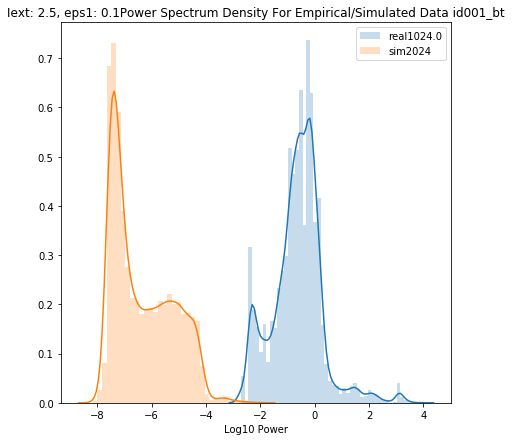

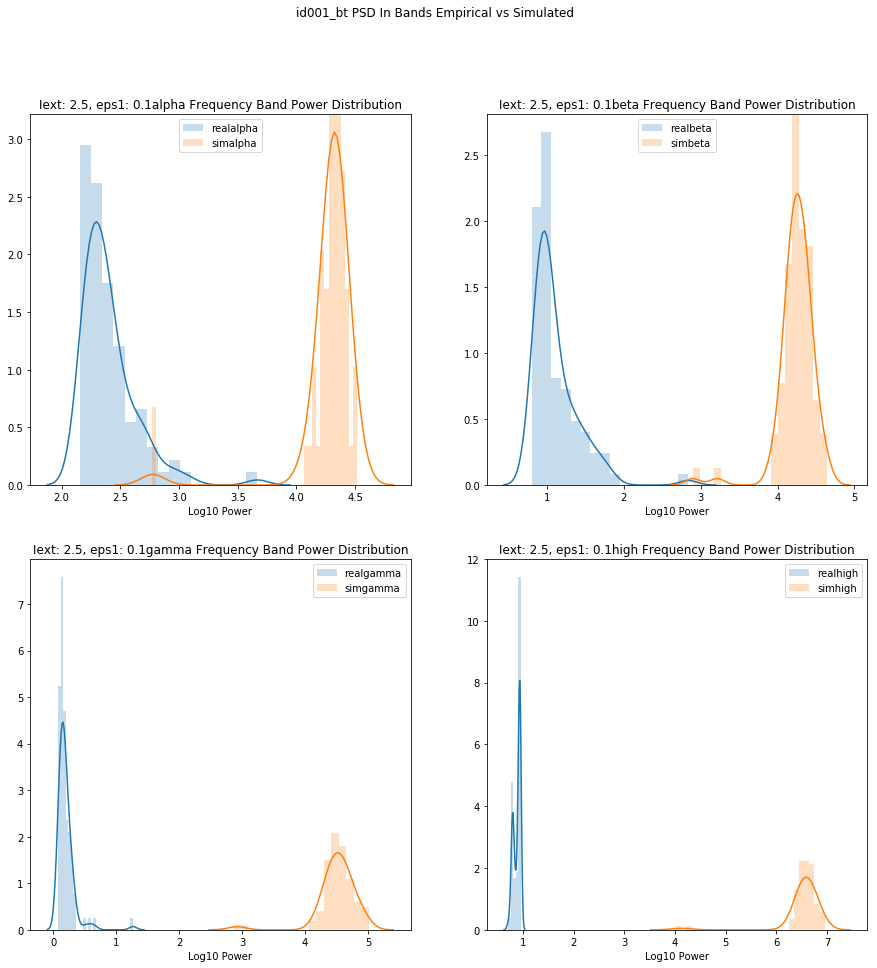

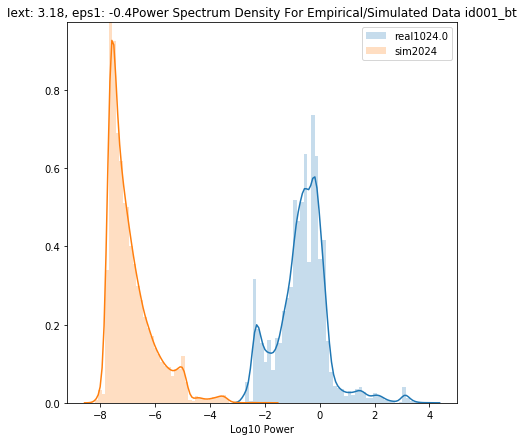

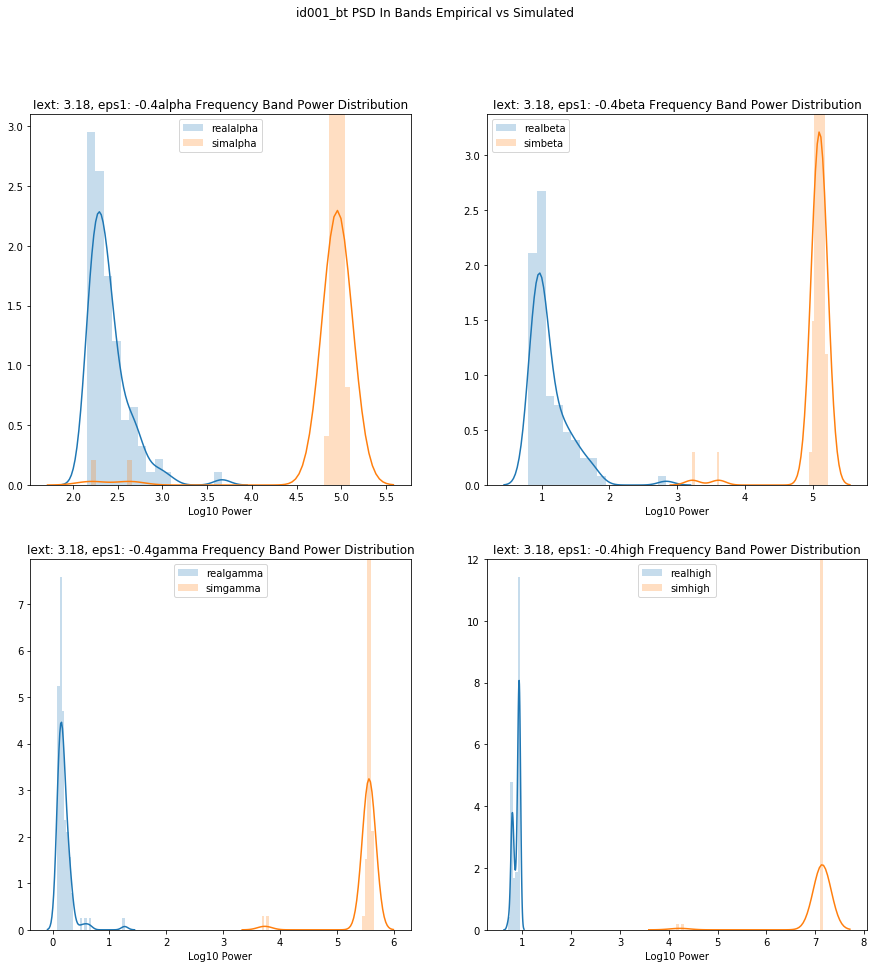

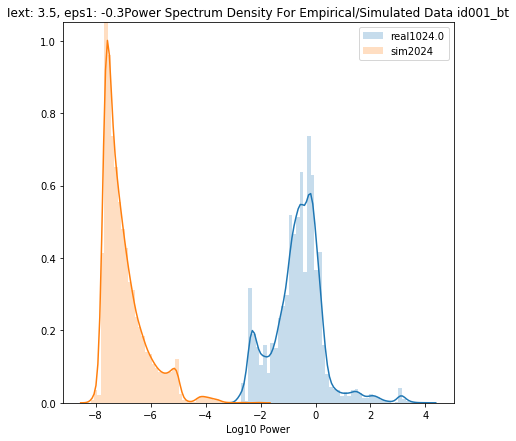

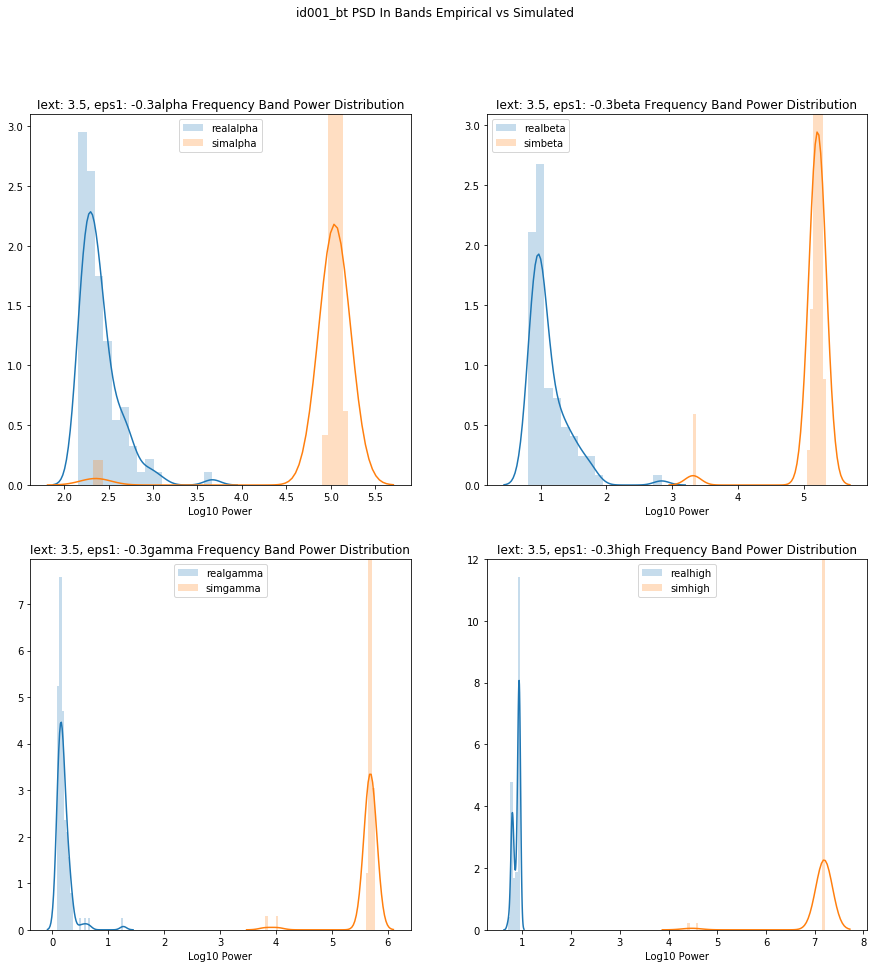

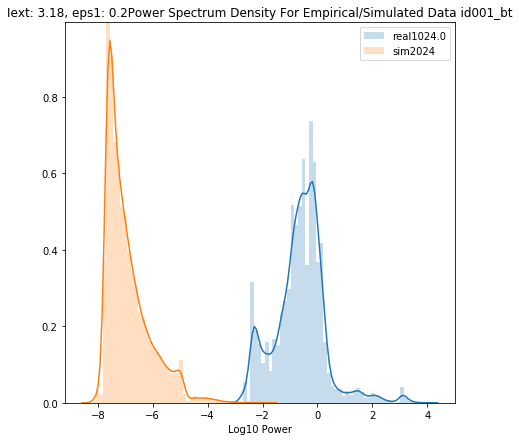

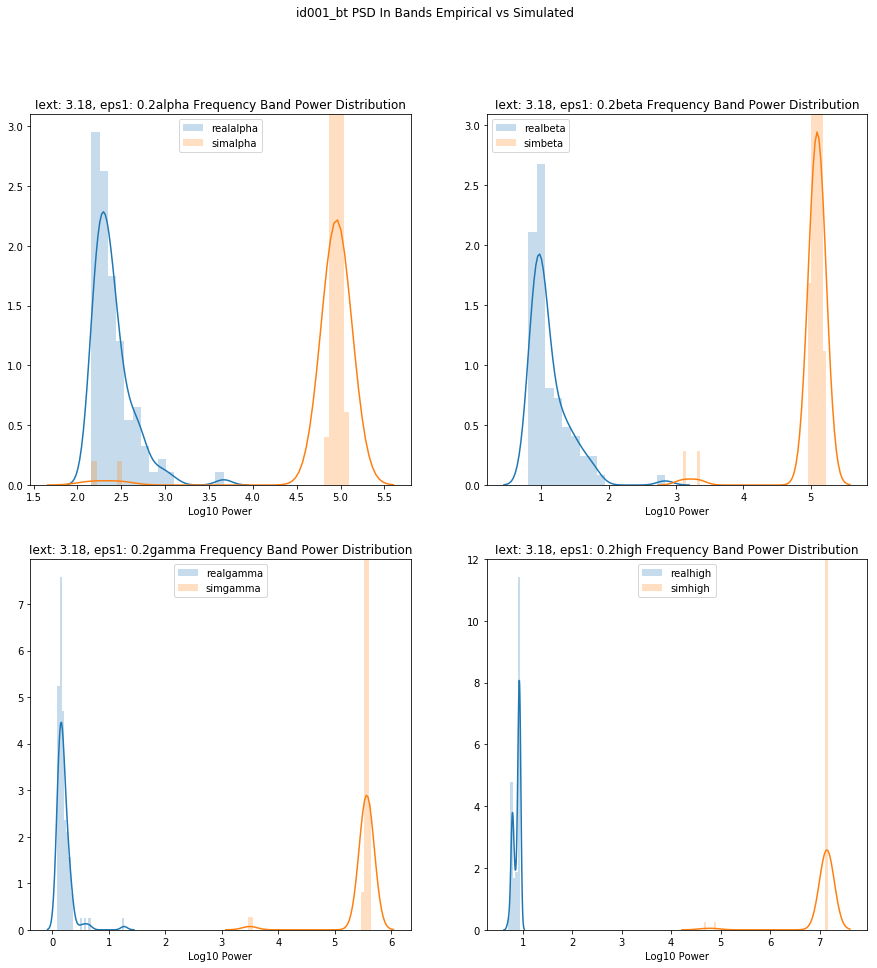

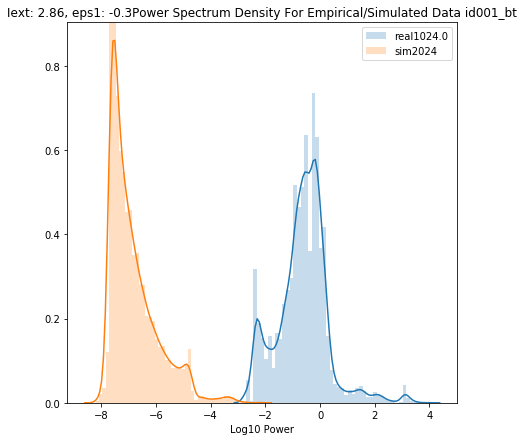

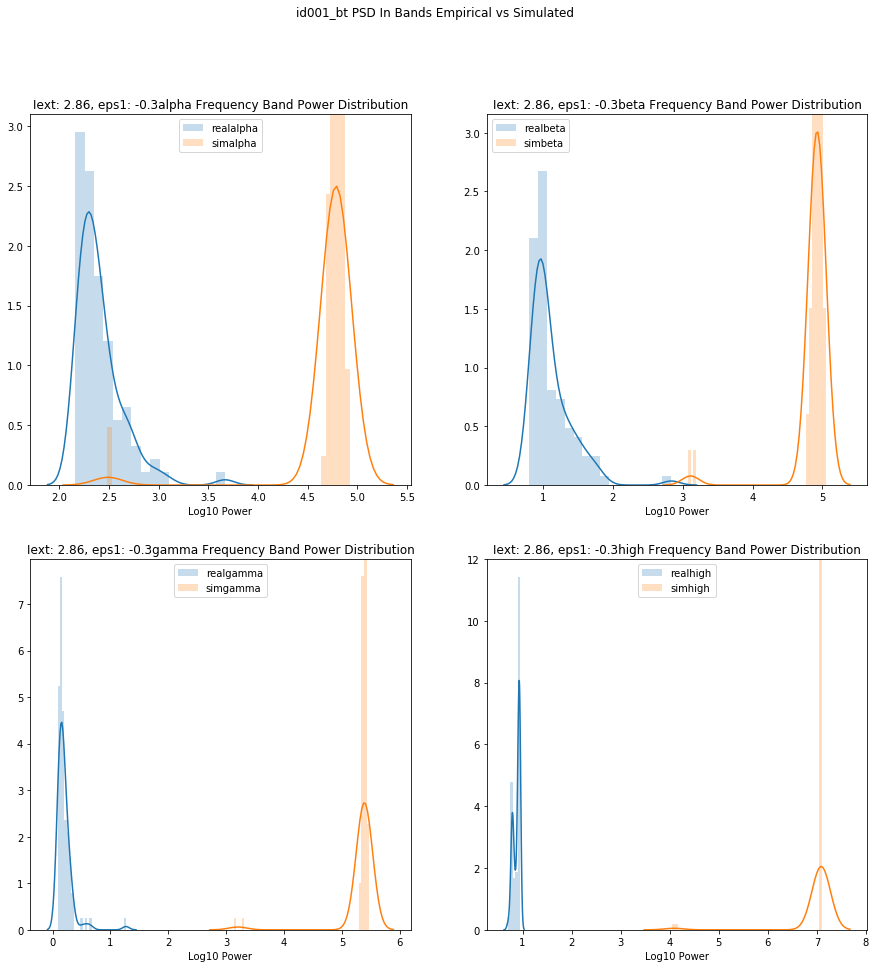

In [19]:
for idx, jsonfile in enumerate(tempjsonfilepaths):
    with io.open(jsonfile, encoding="utf8") as f:
        json_str = f.read()
    metadata = json.loads(json_str)
    datafile = metadata['simfilename']
    datafilename, ext = os.path.splitext(os.path.basename(datafile))
    datafile = os.path.join(outputdatadir, datafilename+ext)
    
    datastruct = np.load(datafile)
    epits = datastruct['epits']
    seegts = datastruct['seegts']
#     print(metadata.keys())
    parameters = jsonfile.split('.json')[0].split(patient+'_')[-1]
    iext, eps1 = parameters.split('_')
    
    ###############################################################
    # Run Sim freq analysis
    simsamplerate = 20242024
    freqs = np.arange(1., simsamplerate//2, 5.)
    fmax = simsamplerate // 2
    waveletfreqs = 2**(np.arange(1.,9.,1./5))
    # for binning frequencies
    simfreqbands = {
        'alpha': [0, 15],
        'beta': [15,30],
        'gamma': [30, 90],
        'high': [90, simsamplerate//2],
    }

    sim_freqanalysis = FreqAnalysis(winsize, stepsize, simsamplerate, freqs)
    simpsd, simfreqs = sim_freqanalysis.psd(epits, fmin, fmax, psdtype='welch')
    sim_freqanalysis.compute_samplepoints(epits.shape[1])

    ###############################################################
    # PLOTTING
    ###############################################################

    plt.figure(figsize=(7,7))
    ax = sns.distplot(psd.ravel(), kde=True, hist_kws={'alpha':0.25}, label='real'+str(samplerate))
    ax = sns.distplot(simpsd.ravel(), kde=True, hist_kws={'alpha':0.25}, label='sim'+str(simsamplerate))
    ax.set_title("Iext: {}, eps1: {}".format(iext, eps1) + 'Power Spectrum Density For Empirical/Simulated Data {}'.format(patient))
    ax.legend()
    plt.xlabel('Log10 Power')
    figfilename = os.path.join(figdir, '{}_{}_{}_psd_comparison_srate{}.pdf'.format(iext, eps1, patient, simsamplerate))
    plt.savefig(figfilename)


    simpower_binned = sim_freqanalysis.binfreqvalues(simpsd, simfreqs, simfreqbands)

    # Plot After binning into frequency bands!
    plt.figure(figsize=(15,15))
    for i in range(len(freqbands)):
        label = sorted(freqbands.keys())[i]
        print(label)
        plt.subplot(2,2,i+1)
        sns.distplot(realpower_binned[:,i,:].ravel(), kde=True,
                         hist_kws={'alpha': 0.25}, label='real'+label)
        sns.distplot(simpower_binned[:,i,:].ravel(), 
                    hist_kws={'alpha': 0.25}, 
                     kde=True, label='sim'+label)
        plt.legend()
        plt.title("Iext: {}, eps1: {}".format(iext, eps1) + '{} Frequency Band Power Distribution'.format(label))
        plt.xlabel('Log10 Power')
        plt.suptitle('{} PSD In Bands Empirical vs Simulated'.format(patient))
        figfilename = os.path.join(figdir, '{}_{}_{}_psd_bands_comparison_srate{}.pdf'.format(iext, eps1,
                                            patient, simsamplerate))
        plt.savefig(figfilename)

    # print some output to debug
    print("{} | Iext: {}, eps1: {}".format(idx, iext, eps1))
    print("real psd: ", max(psd.ravel()), min(psd.ravel()))
    print("sim psd: ", max(simpsd.ravel()), min(simpsd.ravel()))
    print("winsize: ", winsize)
    print("stepsize: ", stepsize)

# Look at Time Frequency Representation

In [10]:
from __future__ import unicode_literals # It seems absolutely needed.

In [5]:
%%time
###############################################################
# Run Real freq analysis
winsize = 5000
stepsize = 2500
samplerate = realmetadata['samplerate']
fmin = 0.5
fmax = samplerate // 2

freqs = np.arange(1., samplerate//2, 5.)
freqs = 2**(np.arange(1.,9.,1./5))

# for binning frequencies
freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}

# run psd analysis
real_freqanalysis = FreqAnalysis(winsize, stepsize, samplerate, freqs)
power, freqs = real_freqanalysis.tfr(rawdata, psdtype='stft')
real_freqanalysis.compute_samplepoints(rawdata.shape[1])

realpower_binned = real_freqanalysis.binfreqvalues(power, freqs, freqbands)

print(realpower_binned.shape)

Number of frequencies: 2501
Number of time steps: 307
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 512.0])
(97, 4, 307)
CPU times: user 4.44 s, sys: 1.62 s, total: 6.06 s
Wall time: 6.12 s


In [6]:
print(power.shape)
print(freqs.shape)

decimation_factor = 100
s = np.random.choice(power.ravel(), len(power.ravel()) // decimation_factor)
# To check the final size
s.shape

(97, 2501, 307)
(2501,)


(744772,)

NameError: name 'simpower' is not defined

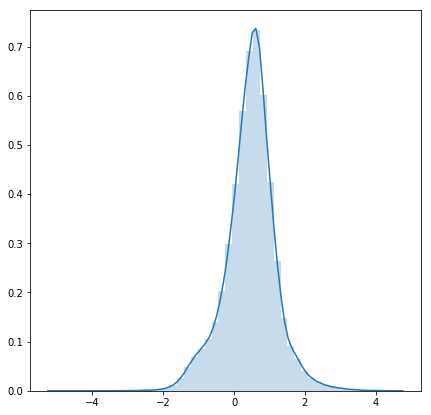

In [22]:
##############################################################
# PLOTTING
###############################################################
plt.figure(figsize=(7,7))
ax = sns.distplot(s.ravel(), kde=True, hist_kws={'alpha':0.25}, label='real'+str(samplerate))
ax = sns.distplot(simpower.ravel(), kde=True, hist_kws={'alpha':0.25}, label='sim'+str(simsamplerate))
ax.set_title('Time-Frequency Power For Empirical/Simulated Data {}'.format(patient))
ax.legend()
plt.xlabel('Log10 Power')
figfilename = os.path.join(figdir, '{}_tfr_psd_comparison_srate{}.pdf'.format(patient, simsamplerate))
plt.savefig(figfilename)

In [7]:
print(len(jsonfilepaths))
tempjsonfilepaths = jsonfilepaths[40:]

print(len(tempjsonfilepaths))

128
88


Number of frequencies: 2501
Number of time steps: 6
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 1024])
alpha
beta
gamma
high
0 | Iext: 2.94, eps1: -0.2
('winsize: ', 5000)
('stepsize: ', 2500)
('Real TFR Binned shape: ', (97, 4, 307))
('Sim TFR Binned shape: ', (161, 4, 6))
Number of frequencies: 2501
Number of time steps: 6
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 1024])
alpha
beta
gamma
high
1 | Iext: 3.3, eps1: 0.3
('winsize: ', 5000)
('stepsize: ', 2500)
('Real TFR Binned shape: ', (97, 4, 307))
('Sim TFR Binned shape: ', (161, 4, 6))
Number of frequencies: 2501
Number of time steps: 6
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 1024])
alpha
beta
gamma
high
2 | Iext: 2.94, eps1: 0.3
('winsize: ', 5000)
('stepsize: ', 2500)
('Real TFR Binned shape: ', (97, 4, 307))
('Sim TFR Binned shape: ', (161, 4, 6))
Number of frequencies: 2501
Number of time steps: 6
('alpha', [0, 15])
('beta', [15, 30])
('ga

IOError: Failed to interpret file u'/Users/adam2392/Downloads/simexp/tt=1/id001_bt_2.6_-0.4.npz' as a pickle

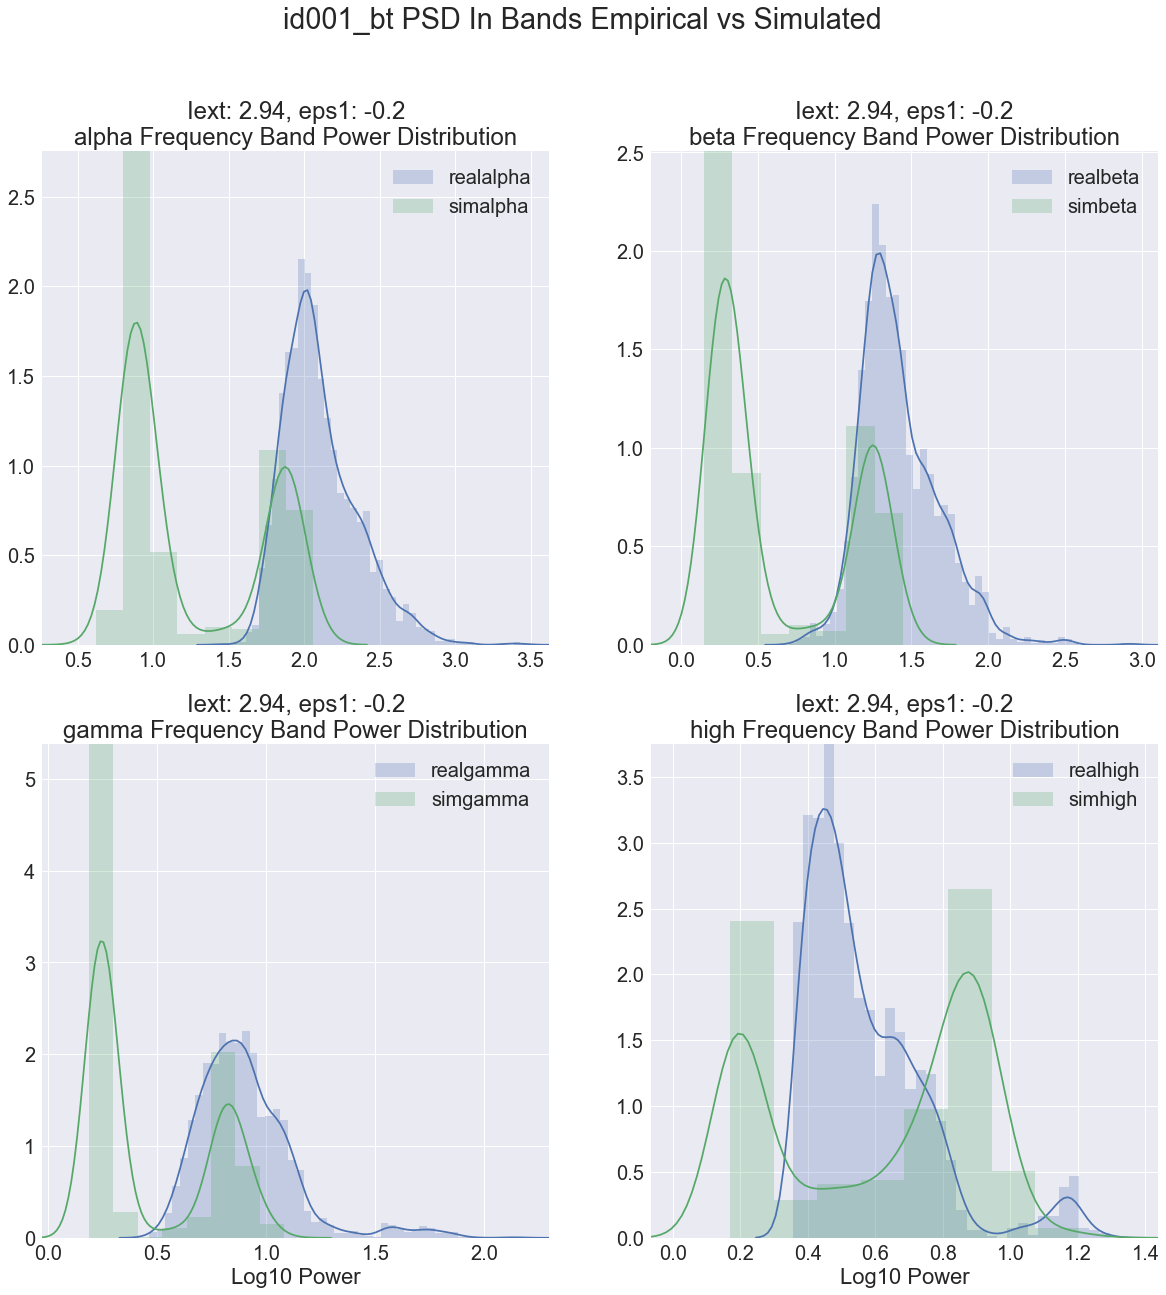

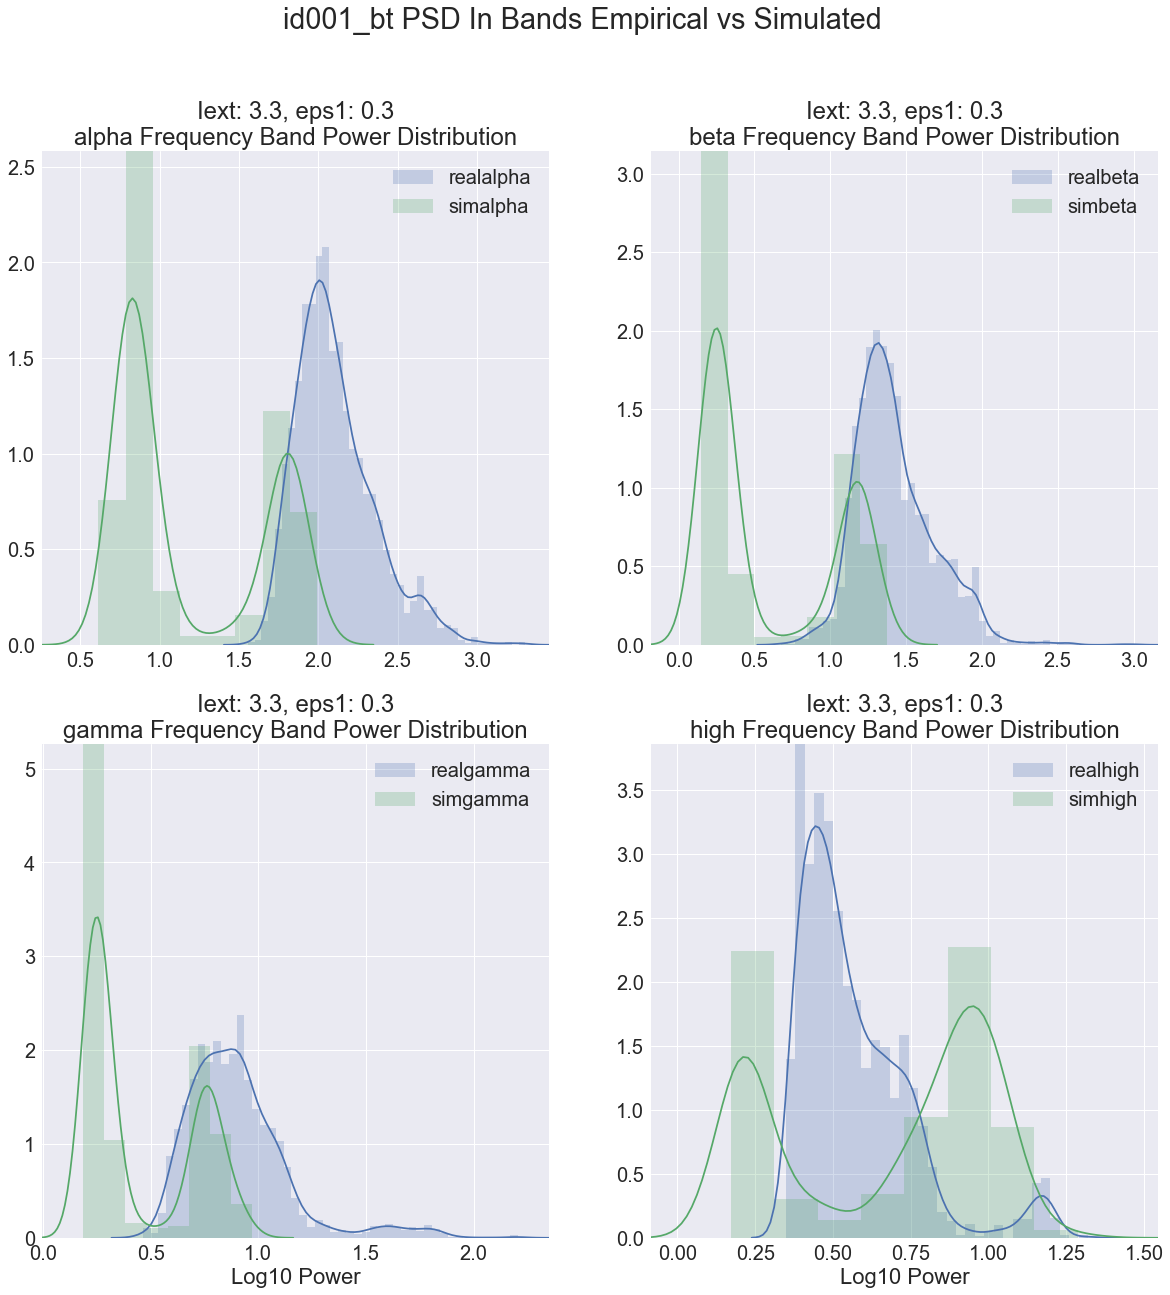

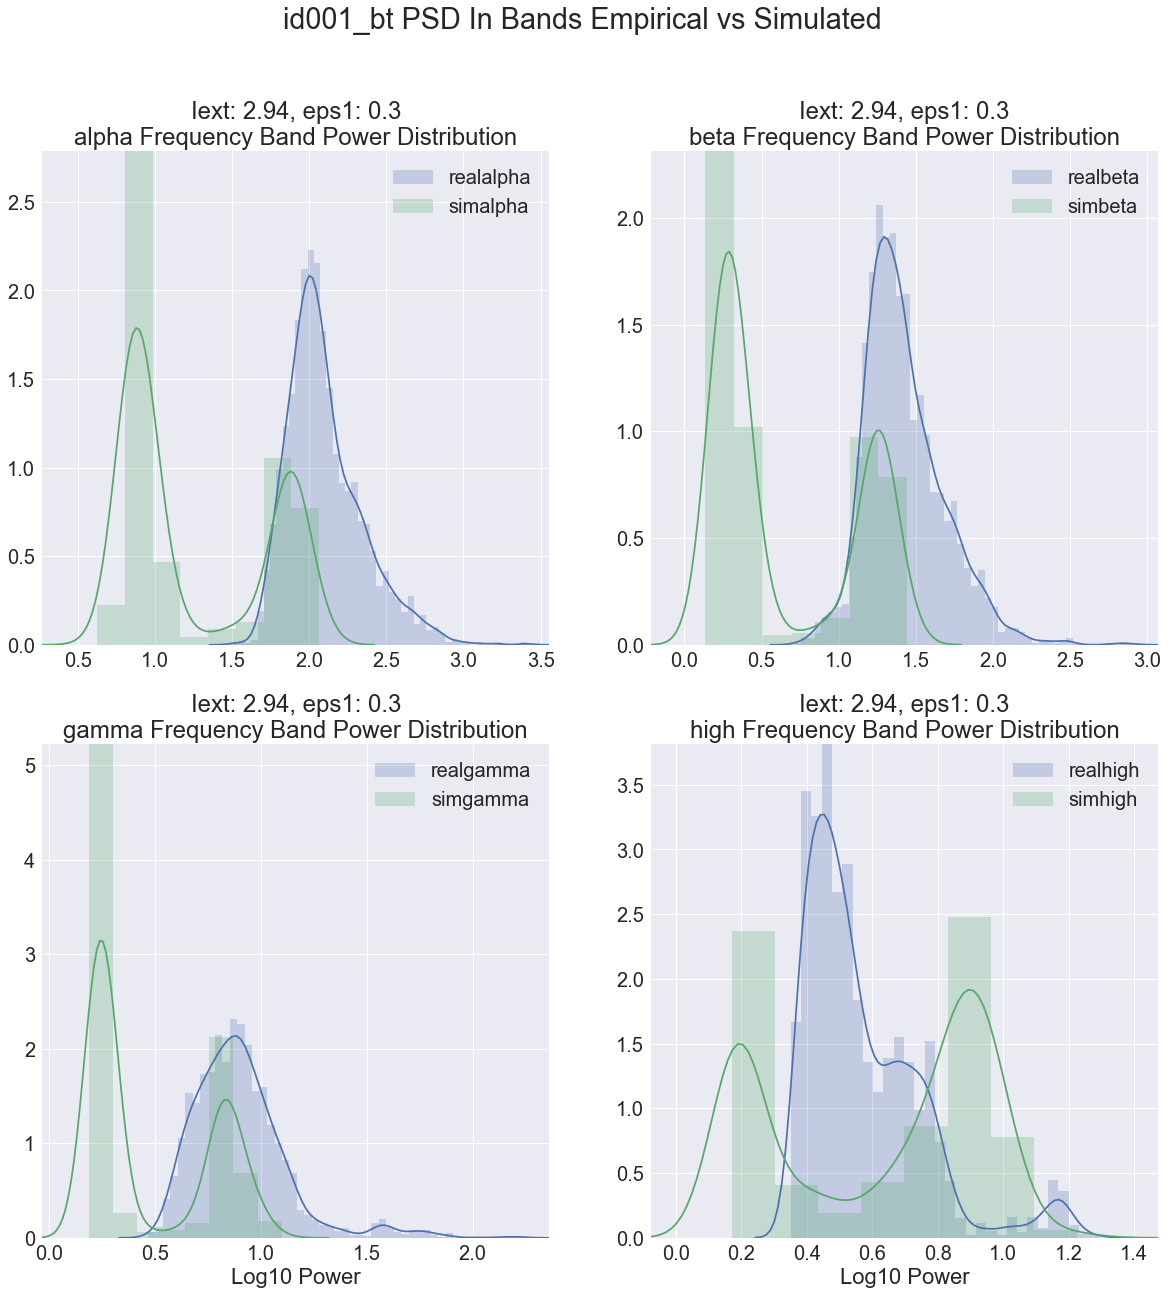

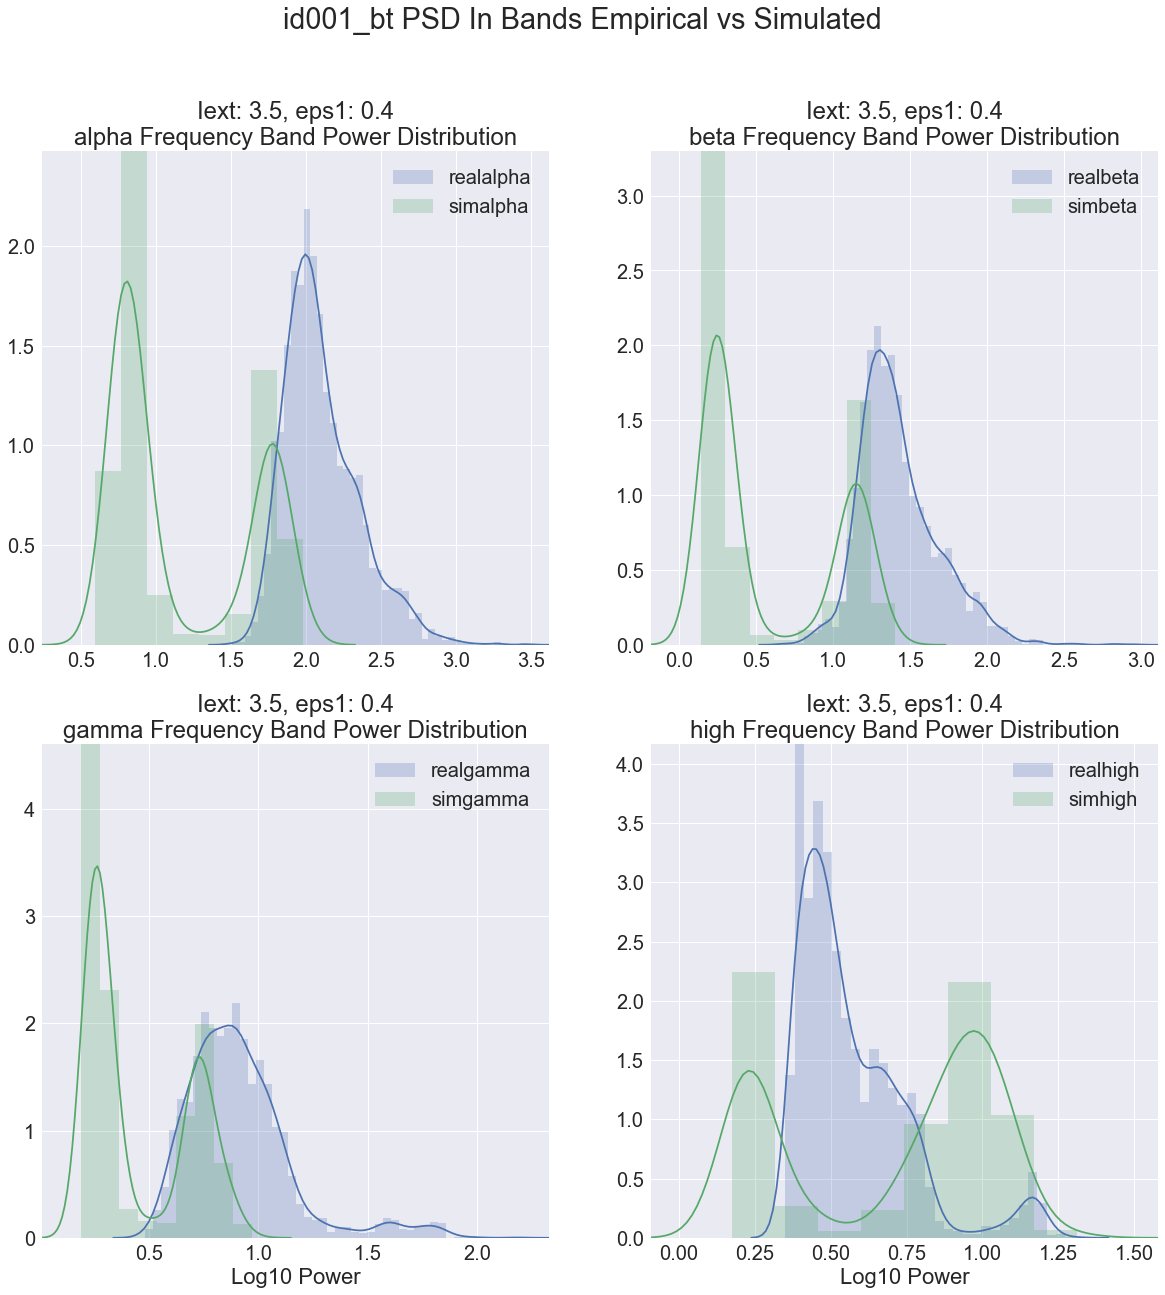

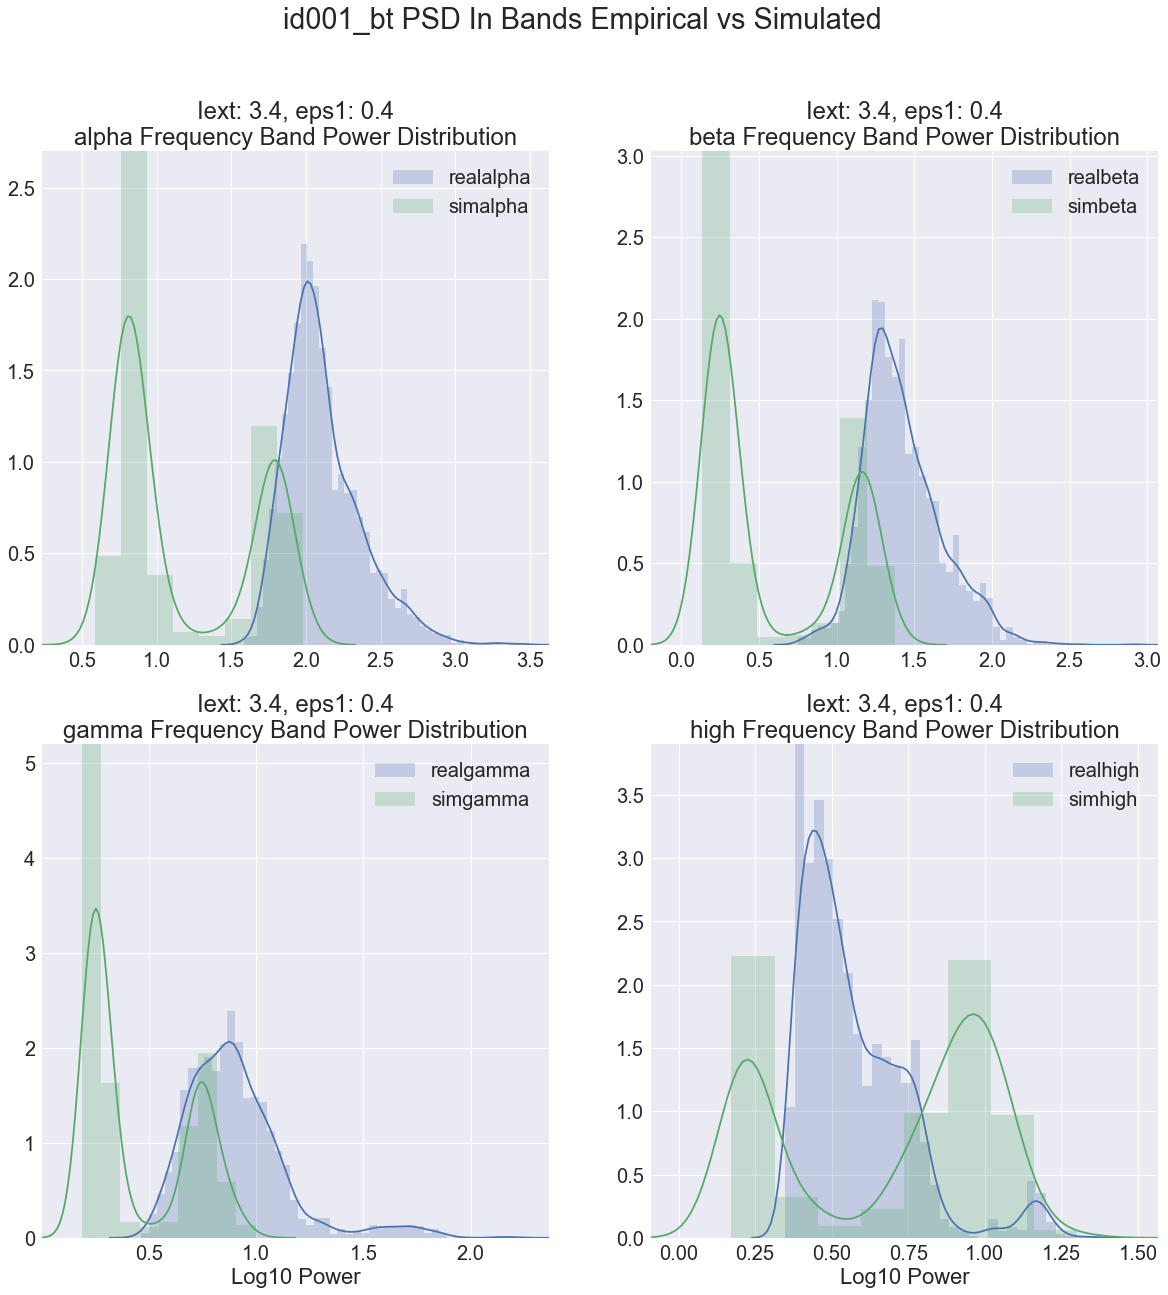

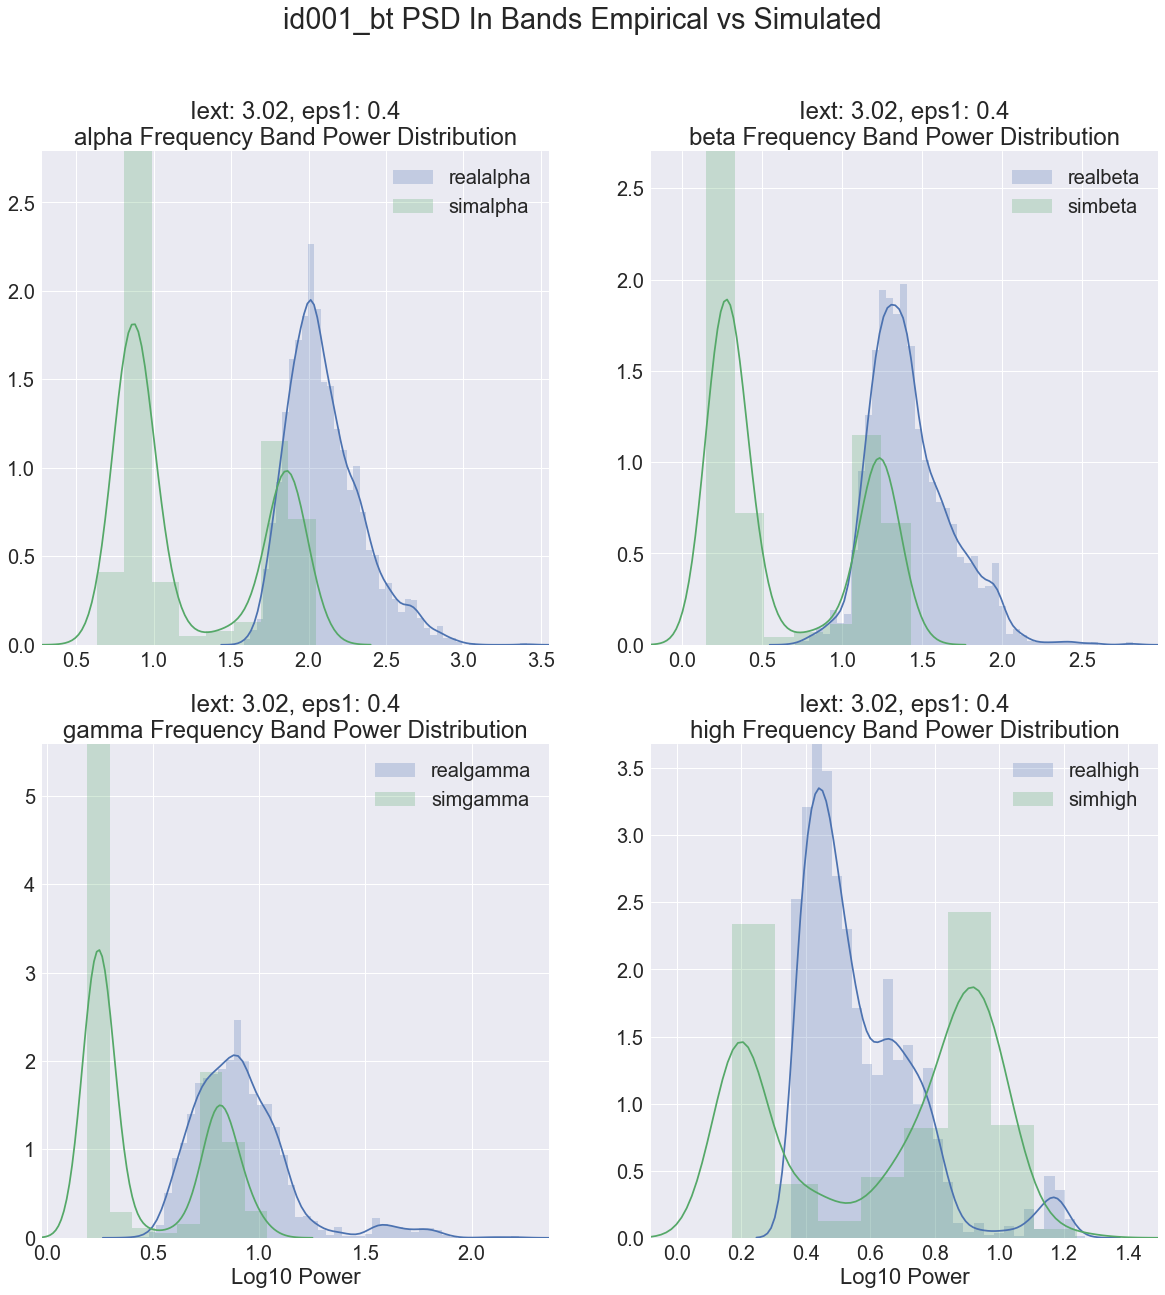

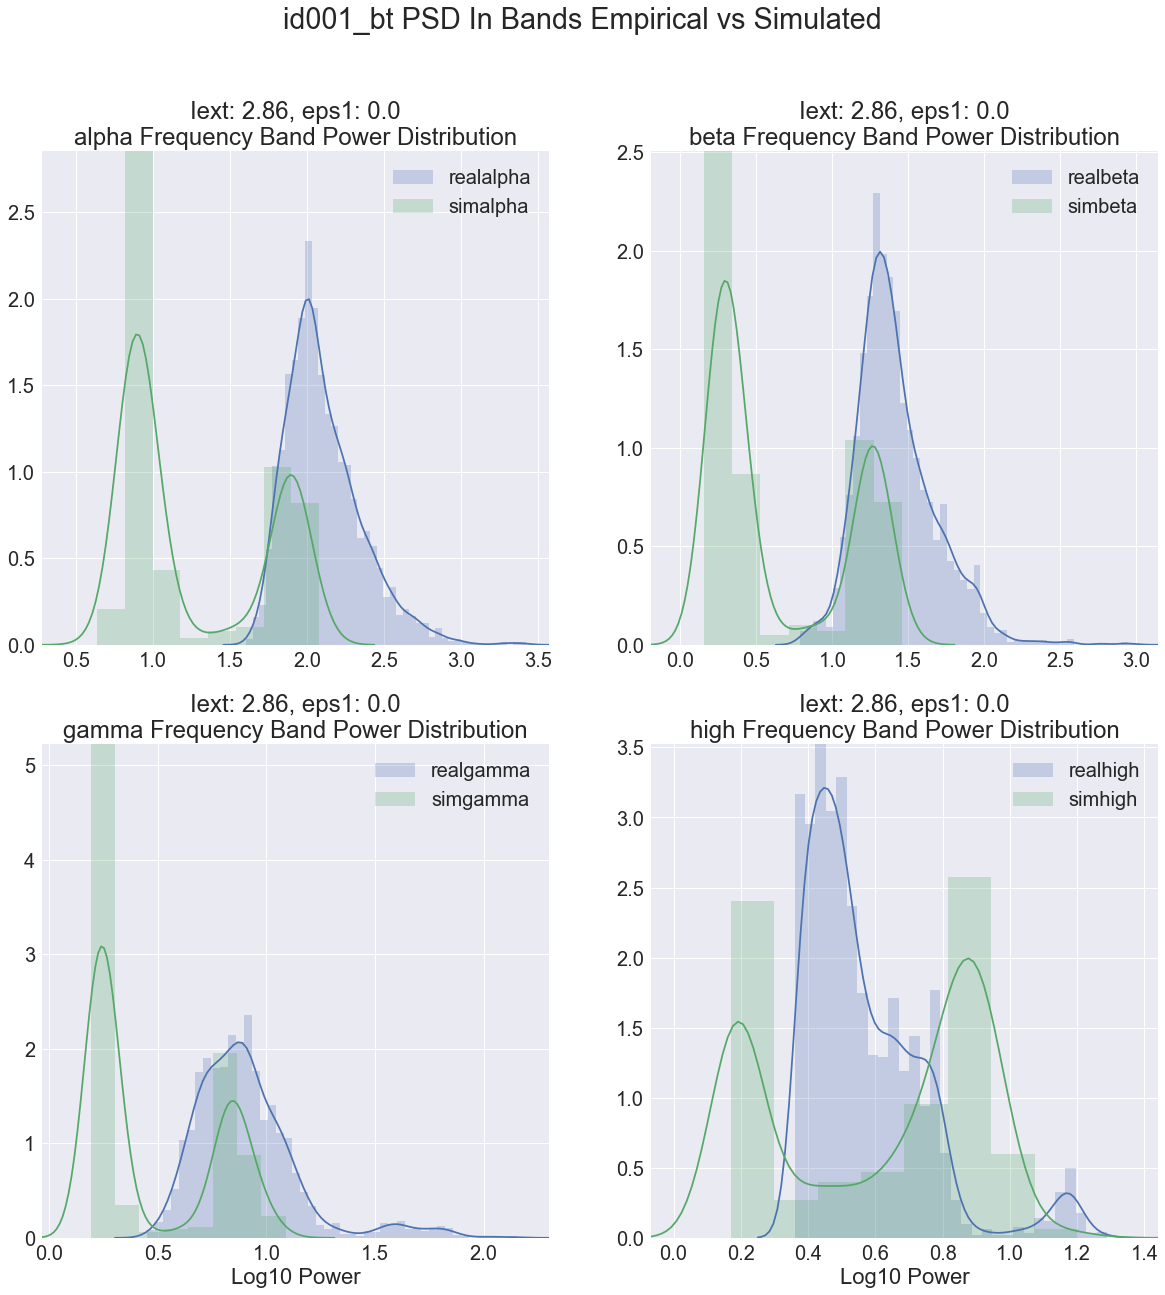

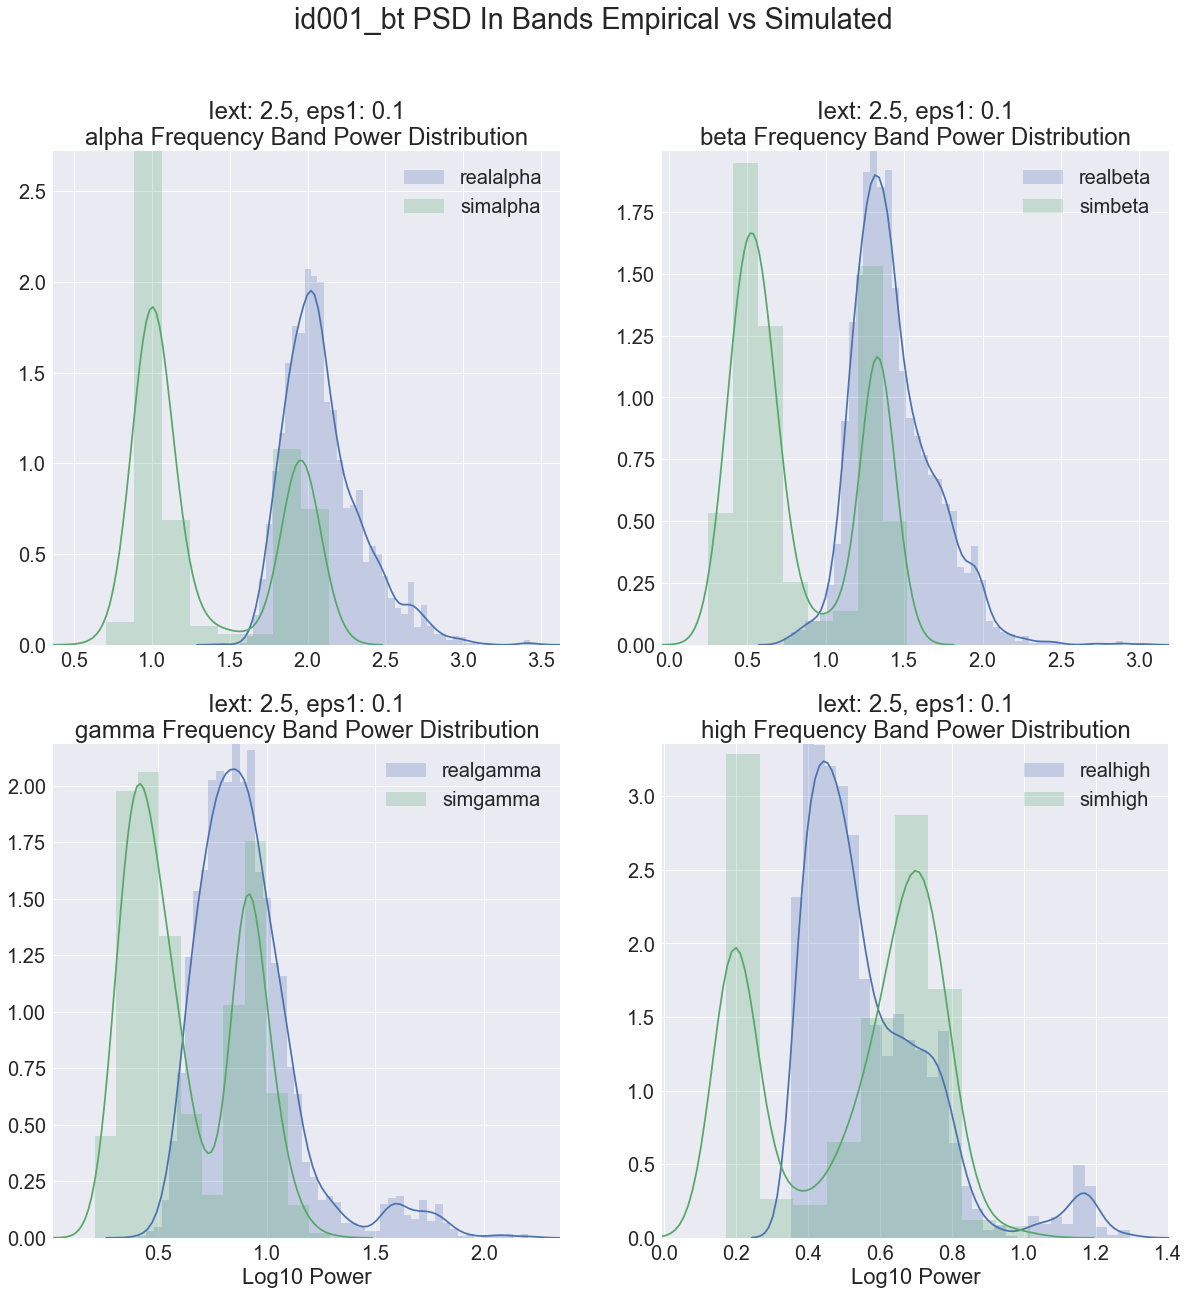

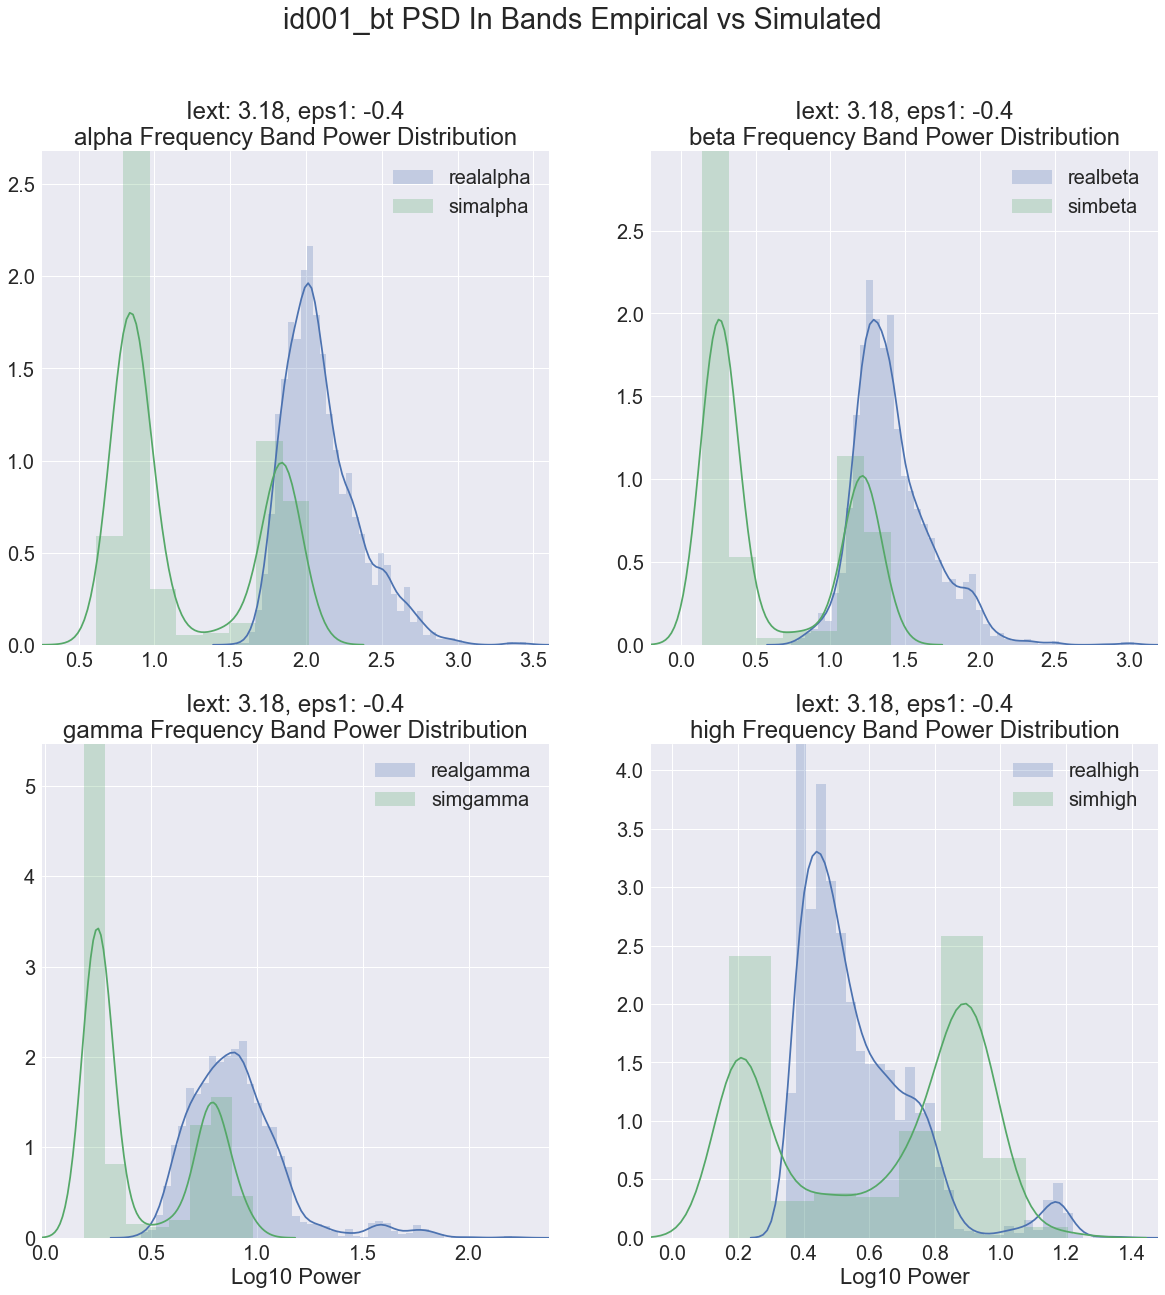

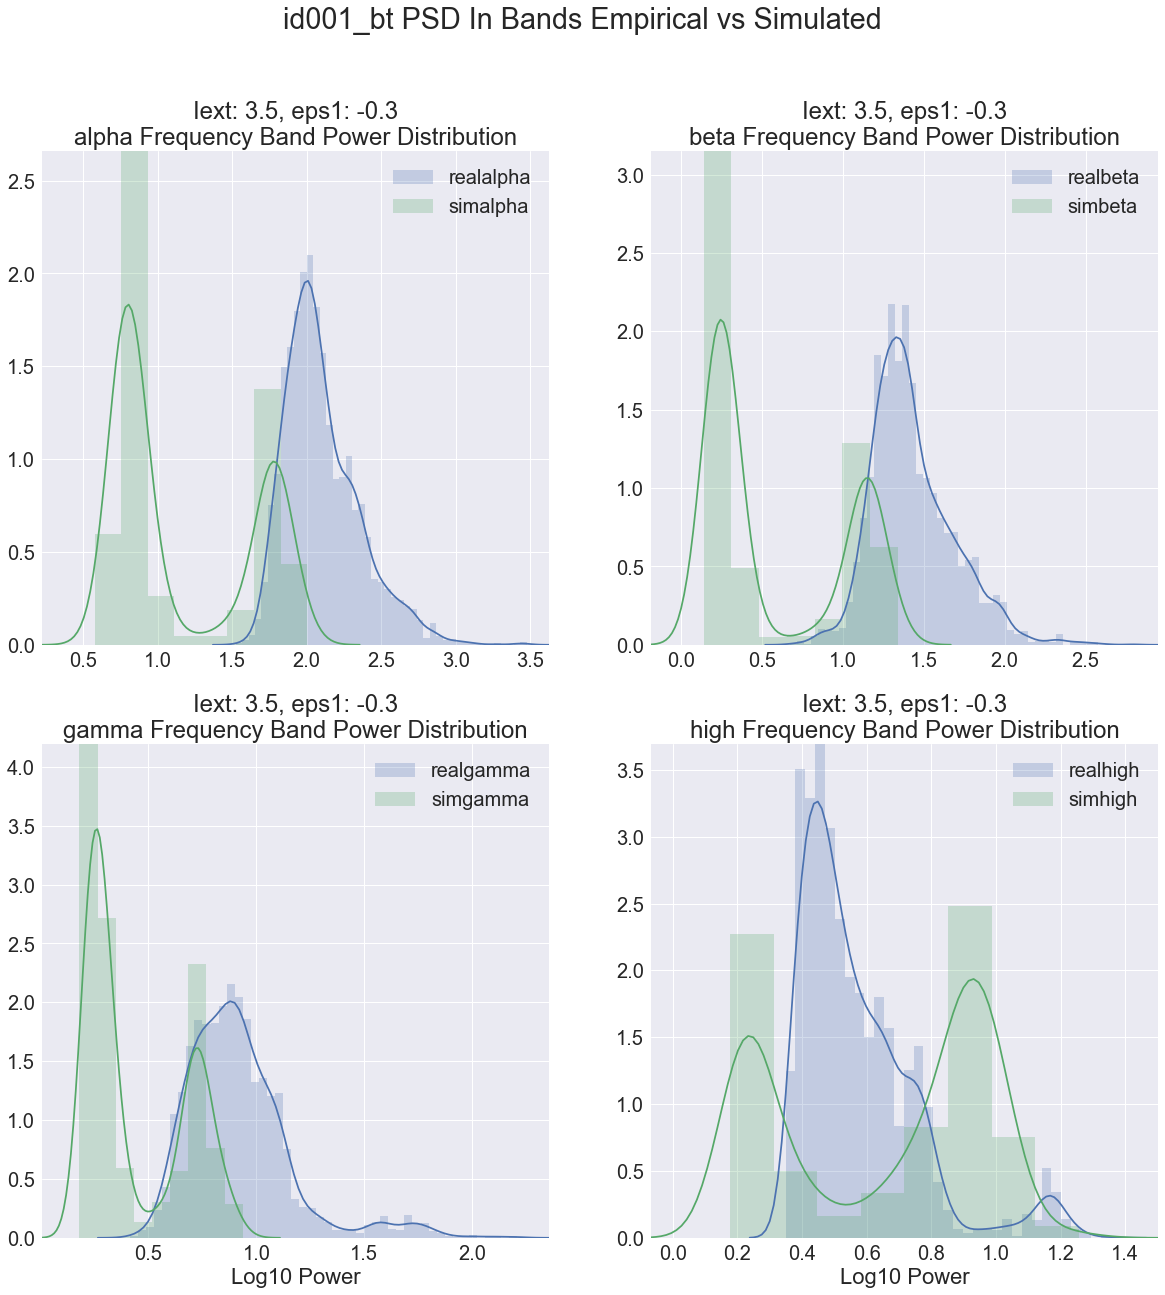

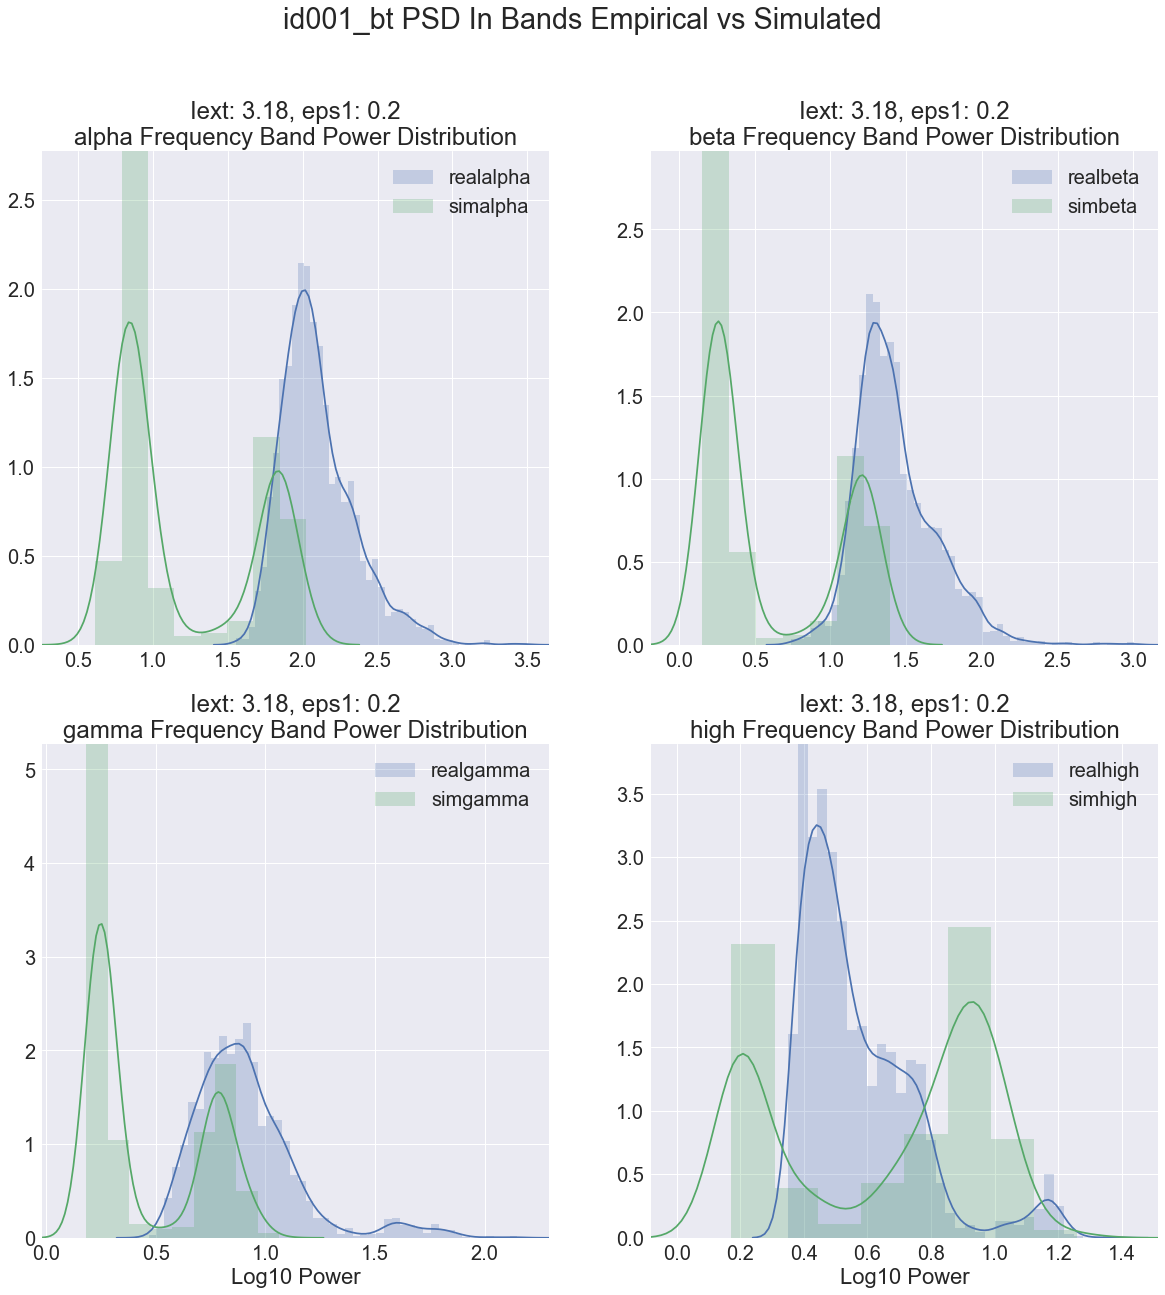

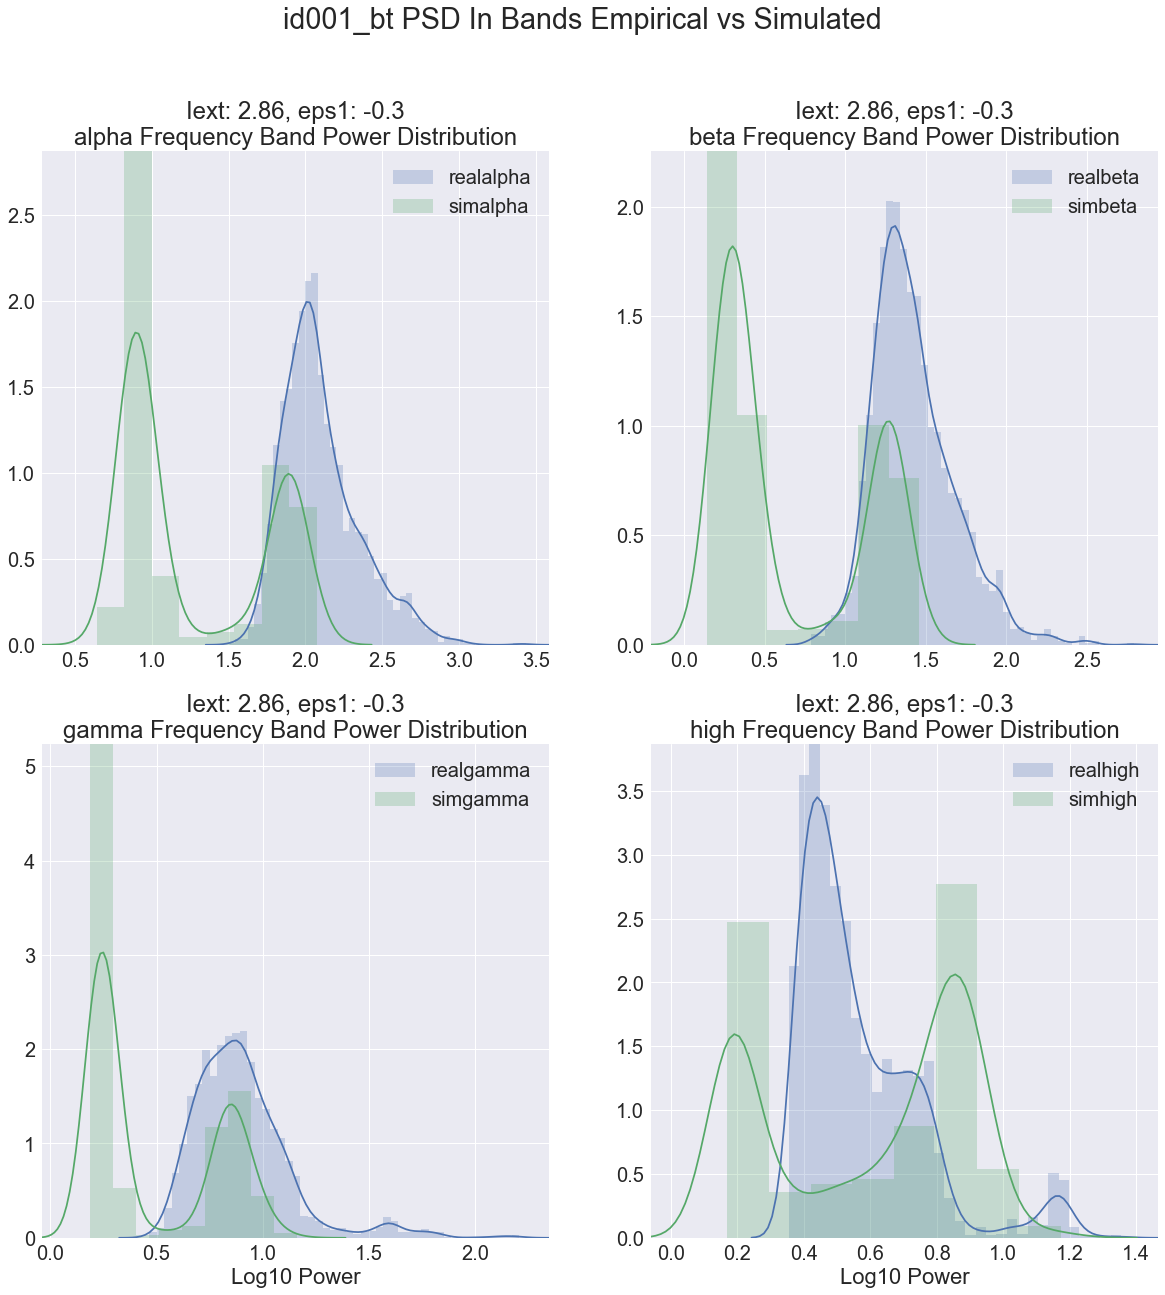

In [8]:
for idx, jsonfile in enumerate(tempjsonfilepaths):
    with io.open(jsonfile, encoding="utf8") as f:
        json_str = f.read()
    metadata = json.loads(json_str)
    datafile = metadata['simfilename']
    datafilename, ext = os.path.splitext(os.path.basename(datafile))
    datafile = os.path.join(outputdatadir, datafilename+ext)
    
    datastruct = np.load(datafile)
    epits = datastruct['epits']
    seegts = datastruct['seegts']
#     print(metadata.keys())
    parameters = jsonfile.split('.json')[0].split(patient+'_')[-1]
    iext, eps1 = parameters.split('_')
    
    ###############################################################
    # Run Sim freq analysis
    simsamplerate = 2048
    freqs = np.arange(1., simsamplerate//2, 5.)
    fmax = simsamplerate // 2
    waveletfreqs = 2**(np.arange(1.,9.,1./5))
    # for binning frequencies
    simfreqbands = {
        'alpha': [0, 15],
        'beta': [15,30],
        'gamma': [30, 90],
        'high': [90, simsamplerate//2],
    }

    sim_freqanalysis = FreqAnalysis(winsize, stepsize, simsamplerate, freqs)
    simpower, simfreqs = sim_freqanalysis.tfr(seegts, psdtype='stft')
    sim_freqanalysis.compute_samplepoints(epits.shape[1])

    simpower_binned = sim_freqanalysis.binfreqvalues(simpower, simfreqs, simfreqbands)

    # Plot After binning into frequency bands!
    plt.figure(figsize=(20,20))
    sns.set(font_scale=2)
    for i in range(len(freqbands)):
        label = sorted(freqbands.keys())[i]
        print(label)
        plt.subplot(2,2,i+1)
        decimation_factor = 10
        s = np.random.choice(realpower_binned[:,i,:].ravel(), len(realpower_binned[:,i,:].ravel()) // decimation_factor)
        # To check the final size
        s.shape
        sns.distplot(s, kde=True,
                         hist_kws={'alpha': 0.25}, label='real'+label)
        sns.distplot(simpower_binned[:,i,:].ravel(), 
                    hist_kws={'alpha': 0.25}, 
                     kde=True, label='sim'+label)
        plt.legend()
        plt.title(u"Iext: {}, eps1: {}".format(iext, eps1) + 
                  u"\n{} Frequency Band Power Distribution".format(label))
        if i == 2 or i == 3:
            plt.xlabel('Log10 Power')
        plt.suptitle('{} PSD In Bands Empirical vs Simulated'.format(patient))
        figfilename = os.path.join(figdir, '{}_{}_{}_tfr_psd_bands_comparison_srate{}.pdf'.format(iext, eps1, patient, simsamplerate))
        ax = plt.gca()
        ax.autoscale(tight=True)
        plt.savefig(figfilename)

    # print some output to debug
    print("{} | Iext: {}, eps1: {}".format(idx, iext, eps1))
    print("winsize: ", winsize)
    print("stepsize: ", stepsize)
    print("Real TFR Binned shape: ", realpower_binned.shape)
    print("Sim TFR Binned shape: ", simpower_binned.shape)
#     break
#     print(real_freqanalysis.samplepoints.shape)
#     print(real_freqanalysis.timepoints.shape)